Importing Libraries

In [125]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

import shap
shap.initjs()

import lime
import lime.lime_tabular

Importing data and filling mising values with NAN

In [2]:
data = pd.read_csv("./diabetic_data.csv")
data.replace('?',np.nan,inplace=True)

EXPLORATORY DATA ANALYSIS
========================

In [44]:
from math import log10
class ExploratoryDataAnalysis:
    def __init__(self,data):
        self.data = data
    
    def get_feature_class_count(self,col):
        count_map = {}
        for x in col:
            if(x in count_map):
                count_map[x] = count_map[x] + 1
            else:
                count_map[x] = 1

        return log10(len(count_map))
    
    def get_missing_counts(self,col):
        return len(col) - col.count()
    
    # This plots the number of unique values per feature in a histogram plot
    def plot_class_counts(self,plot_missing_feature_count = False):
        class_counts = [self.get_feature_class_count(self.data[column]) for column in self.data]
        data = [go.Histogram(x=self.data.columns, y=class_counts)]
        trace = go.Bar(
            x=self.data.columns,
            y=class_counts
        )
        layout = go.Layout(
            title='Feature counts | Total number of rows=' + str(len(self.data)),
            xaxis = dict(title='Features'),
            yaxis = dict(title='Log(Number of unique values)')
        )
        py.iplot(go.Figure(data=[trace], layout=layout))
    
    # This plots the number of unique values per class labels
    def plot_class_count(self):
        count_NO = 0
        count_less_30 = 0
        for x in self.data["readmitted"]:
            if(x == "NO"):
                count_NO = count_NO + 1
            elif (x == "<30"):
                count_less_30 = count_less_30 + 1

        trace = go.Bar(
            x=[">30","<30","NO"],
            y=[(len(self.data) - count_NO  - count_less_30),count_less_30,count_NO]
        )
        layout = go.Layout(
            title='Class counts | Total number of rows=' + str(len(self.data)),
            xaxis = dict(title='Features'),
            yaxis = dict(title='Log(Number of unique values)')
        )
        py.iplot(go.Figure(data=[trace], layout=layout))
    
    # This plots the number of missing values per features
    def plot_missing_count(self):
        class_counts = [len(self.data[column]) for column in self.data]
        missing_counts = [self.get_missing_counts(self.data[column]) for column in self.data]
        data = [go.Histogram(x=self.data.columns, y=class_counts)]
        trace = go.Bar(
            x=self.data.columns,
            y=class_counts
        )
        trace_missing = go.Bar(
            x=self.data.columns,
            y=missing_counts
        )
        layout = go.Layout(
            title='Feature counts | Total number of rows=' + str(len(self.data)),
            xaxis = dict(title='Features'),
            yaxis = dict(title='Log(Number of unique values)')
        )
        py.iplot(go.Figure(data=[trace,trace_missing], layout=layout))
        

    

In [4]:
EDA = ExploratoryDataAnalysis(data)
EDA.plot_class_counts()
EDA.plot_class_count()
EDA.plot_missing_count()

FEATURE ENGINEERING
===================

In [117]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack,vstack


# This is a class compatible with Sklearn's pipeline
# It does one hot encoding for categorical features
# and replaces values of count less than the threshold count
# with UNK token
class OneHotEncoderWithFeaturePrunning:
    def __init__(self,threshold_count=50,dummy_variable="UNK"):
        self.enc = CountVectorizer(analyzer='char_wb',lowercase=False)
        self.frequency_map = {}
        self.threshold_count = threshold_count
        
        
    def fit(self,data):
        map(self._process_frequencies,enumerate(data))
        map(self._process_rare_data,enumerate(data))
        return self.enc.fit(data)
        
    def _process_frequencies(self,data,index):
        if(data[index] not in self.frequency_map):
            self.frequency_map[data[index]] = 1
        else:
            self.frequency_map[data[index]] = self.frequency_map[data[index]] + 1
            
    def _process_rare_data(self,data,index):
        if(self.frequency_map[data[index]] <= self.threshold_count):
            data[index] = self.dummy_variable
            
    def fit_transform(self,data):
        map(self._process_frequencies,enumerate(data))
        map(self._process_rare_data,enumerate(data))
        return self.enc.fit_transform(data)
    
    def transform(self,data):
        map(self._process_rare_data,enumerate(data))
        return self.enc.transform(data)
            
    def get_encoder(self):
        return self.enc

# This is a class compatible with Sklearn's Pipeline
# which does one hot encoding for categorical features
# and keeps the numerical features as it is
class FeatureEngineering:
       
    def get_encoding(self,column):
        categorical_encoder = OneHotEncoderWithFeaturePrunning()
        return categorical_encoder.fit_transform(column.astype('str')), categorical_encoder
    
    def fit(self,data,y):
        self.categorical_indices={
            "race":True,
            "gender": True,
            "age":True,
            "admission_type_id":True,
            "discharge_disposition_id":True,
            "admission_source_id": True,
            "time_in_hospital": False,
            "num_lab_procedures":False,
            "num_procedures":False,
            "num_medications":False,
            "number_outpatient":False,
            "number_emergency":False,
            "number_inpatient":False,
            "diag_1":True,
            "diag_2":True,
            "diag_3":True,
            "number_diagnoses":False,
            "max_glu_serum":True,
            "A1Cresult":True,
            "metformin":True,
            "repaglinide":True,
            "nateglinide":True,
            "chlorpropamide":True,
            "glimepiride":True,
            "acetohexamide":True,
            "glipizide":True,
            "glyburide":True,
            "tolbutamide":True,
            "pioglitazone":True,
            "rosiglitazone":True,
            "acarbose":True,
            "miglitol":True,
            "troglitazone":True,
            "tolazamide":True,
            "insulin":True,
            "glyburide-metformin":True,
            "glipizide-metformin":True,
            "metformin-rosiglitazone":True,
            "metformin-pioglitazone":True,
            "change":True,
            "diabetesMed":True
        }
        x = None
        self.encoder = {}
        self.index_feature_map = {}
        index = 0
        for label, column in data.items():
            if(label in self.categorical_indices):
                if(self.categorical_indices[label] == True):
                    encoded_data,self.encoder[label] = self.get_encoding(column)
                    x = encoded_data if x == None else hstack([x,encoded_data],format="csr")
                    feature_classes = list(self.encoder[label].enc.vocabulary_.values())
                    for i in range(0,len(feature_classes)):
                        self.index_feature_map[index] = str(label) + "|" + str(feature_classes[i])
                        index = index + 1
                    
                else:
                    self.index_feature_map[index] = label
                    index = index + 1
                    x = column if x == None else hstack([x,((pd.DataFrame(column.astype('float64'))).to_sparse())],format="csr")
        return x.toarray()
    
    def fit_transform(self,data,y):
        return self.fit(data,y)
    
    def transform(self,data):
        x = None
        for label, column in data.items():
            if(label in self.categorical_indices):
                if(self.categorical_indices[label] == True):
                    encoded_data = (self.encoder[label]).transform(column.astype('str'))
                    x = encoded_data if x == None else hstack([x,encoded_data])
                else:
                    x = column if x == None else hstack([x,(pd.DataFrame(column).to_sparse())])
        return x.toarray()
    

In [118]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack,vstack


# This is a class compatible with Sklearn's Pipeline
# meant for tree-like models
# which label encoding for categorical features
# and keeps the numerical features as it is
class FeatureEngineeringForTrees:
       
    def get_encoding(self,column):
        categorical_encoder = LabelEncoder()
        return categorical_encoder.fit_transform(column.astype('str')), categorical_encoder
    
    def fit(self,data,y):
        self.categorical_indices={
            "race":True,
            "gender": True,
            "age":True,
            "admission_type_id":True,
            "discharge_disposition_id":True,
            "admission_source_id": True,
            "time_in_hospital": False,
            "num_lab_procedures":False,
            "num_procedures":False,
            "num_medications":False,
            "number_outpatient":False,
            "number_emergency":False,
            "number_inpatient":False,
            "diag_1":True,
            "diag_2":True,
            "diag_3":True,
            "number_diagnoses":False,
            "max_glu_serum":True,
            "A1Cresult":True,
            "metformin":True,
            "repaglinide":True,
            "nateglinide":True,
            "chlorpropamide":True,
            "glimepiride":True,
            "acetohexamide":True,
            "glipizide":True,
            "glyburide":True,
            "tolbutamide":True,
            "pioglitazone":True,
            "rosiglitazone":True,
            "acarbose":True,
            "miglitol":True,
            "troglitazone":True,
            "tolazamide":True,
            "insulin":True,
            "glyburide-metformin":True,
            "glipizide-metformin":True,
            "metformin-rosiglitazone":True,
            "metformin-pioglitazone":True,
            "change":True,
            "diabetesMed":True
        }
        x = None
        self.encoder = {}
        self.index_feature_map = {}
        index = 0
        for label, column in data.items():
            if(label in self.categorical_indices):
                self.index_feature_map[index] = label
                index = index + 1
                if(self.categorical_indices[label] == True):
                    encoded_data,self.encoder[label] = self.get_encoding(column)
                    encoded_data = encoded_data.reshape(-1,1)
                    x = encoded_data if x is None else np.hstack((x,encoded_data))
                else:
                    x = column if x is None else np.hstack((x,column.values.reshape(-1,1)))
        return x
    
    def fit_transform(self,data,y):
        return self.fit(data,y)
    
    def transform(self,data):
        x = None
        for label, column in data.items():
            if(label in self.categorical_indices):
                if(self.categorical_indices[label] == True):
                    encoded_data,self.encoder[label] = self.get_encoding(column)
                    encoded_data = encoded_data.reshape(-1,1)
                    x = encoded_data if x is None else np.hstack((x,encoded_data))
                else:
                    x = column if x is None else np.hstack((x,column.values.reshape(-1,1)))
        return x
    

EVALUATION METRICS
=================

In [7]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from inspect import signature
from sklearn.metrics import average_precision_score

def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,2), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_prauc(y_test,y_score):
    average_precision = average_precision_score(y_test, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
    plt.show()

    
def print_raoc(y_test,y_score):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
def print_result(y_test1, y_pred1, y_pred_proba1=0):
    cm = confusion_matrix(y_test1, y_pred1, labels=[0,1])
    print_confusion_matrix(cm, [0, 1])
    print(classification_report(y_test1, y_pred1))
    
from sklearn.metrics import confusion_matrix, classification_report
def generate_results(clf,X_test,y_test):
    pred = clf.predict(X_test)
    print_result(y_test, pred)
    score = clf.decision_function(X_test)
    print_prauc(y_test, score)
    print_raoc(y_test, score)
    
def generate_results_for_trees(clf,X_test,y_test):
    pred = clf.predict(X_test)
    print_result(y_test, pred)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
def split_data(x,label):
    X_train, X_test, y_train, y_test = train_test_split(x, label, test_size=0.20)
    return X_train, X_test, y_train, y_test

# y = (data["readmitted"].astype('str')).apply(lambda x: 0 if x == "NO" else (1 if x == "<30" else 2))
y = (data["readmitted"].astype('str')).apply(lambda x: 0 if x == "NO" else 1)
X_train, X_test, y_train, y_test = split_data(data,y) 

Using TensorFlow backend.


DECISION TREES
==============


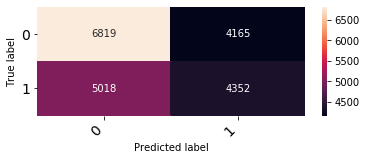

              precision    recall  f1-score   support

           0       0.58      0.62      0.60     10984
           1       0.51      0.46      0.49      9370

    accuracy                           0.55     20354
   macro avg       0.54      0.54      0.54     20354
weighted avg       0.55      0.55      0.55     20354



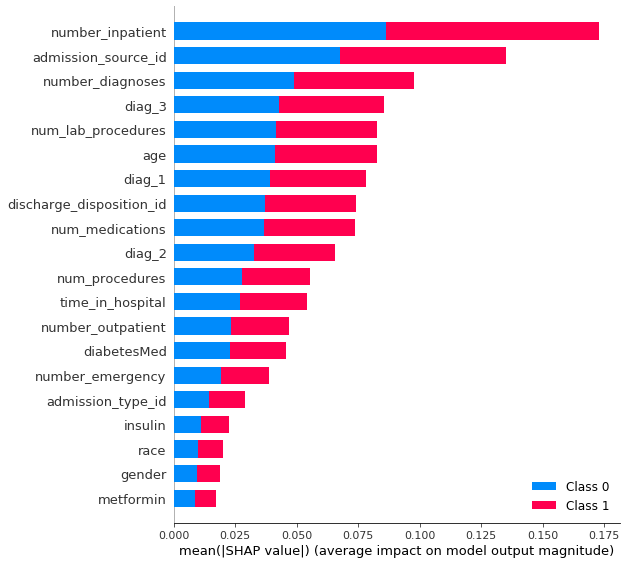

In [70]:
feature_engineering = FeatureEngineeringForTrees()
encoded_training_data = feature_engineering.fit_transform(X_train,y_train)
clf = DecisionTreeClassifier()
clf.fit(encoded_training_data,y_train)
encoded_test_data = feature_engineering.transform(X_test)
generate_results_for_trees(clf,encoded_test_data,y_test)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(encoded_test_data,y_test)
shap.force_plot(explainer.expected_value[0], shap_values[0][0:100],encoded_test_data,list(feature_engineering.index_feature_map.values()))
shap.summary_plot(shap_values,encoded_test_data,list(feature_engineering.index_feature_map.values()))

In [71]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0:100],encoded_test_data,list(feature_engineering.index_feature_map.values()))

In [ ]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(encoded_training_data,class_names=y_train.unique(),verbose=True, mode='classification')

RANDOM FOREST
==============

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



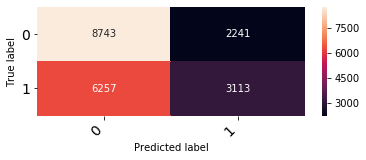

              precision    recall  f1-score   support

           0       0.58      0.80      0.67     10984
           1       0.58      0.33      0.42      9370

    accuracy                           0.58     20354
   macro avg       0.58      0.56      0.55     20354
weighted avg       0.58      0.58      0.56     20354



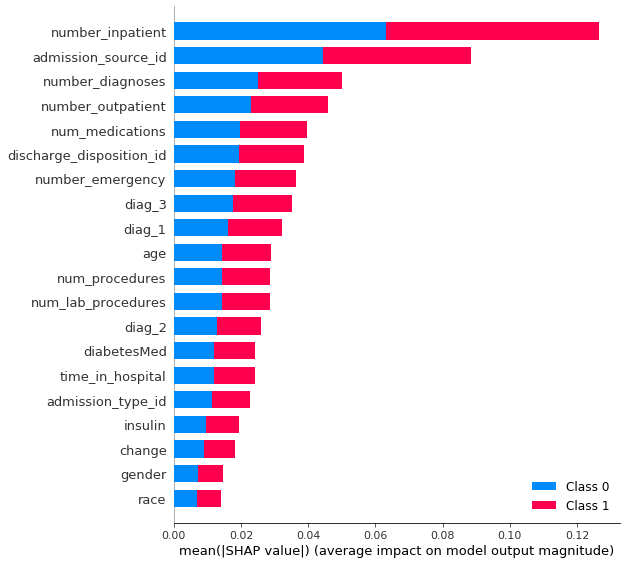

In [72]:
rf = RandomForestClassifier()
rf.fit(encoded_training_data,y_train)
encoded_test_data = feature_engineering.transform(X_test)
generate_results_for_trees(rf,encoded_test_data,y_test)
rf_explainer = shap.TreeExplainer(rf)
rf_shap_values = rf_explainer.shap_values(encoded_test_data,y_test)
shap.force_plot(rf_explainer.expected_value[0], rf_shap_values[0][0:100],encoded_test_data,list(feature_engineering.index_feature_map.values()))
shap.summary_plot(rf_shap_values,encoded_test_data,list(feature_engineering.index_feature_map.values()))

In [73]:
shap.force_plot(rf_explainer.expected_value[0], rf_shap_values[0][0:100],encoded_test_data,list(feature_engineering.index_feature_map.values()))

LOGISTIC REGRESSION
==================

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



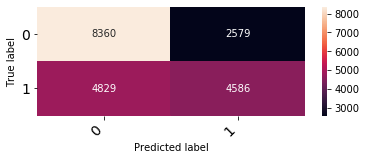

              precision    recall  f1-score   support

           0       0.63      0.76      0.69     10939
           1       0.64      0.49      0.55      9415

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.62     20354
weighted avg       0.64      0.64      0.63     20354

Average precision-recall score: 0.65


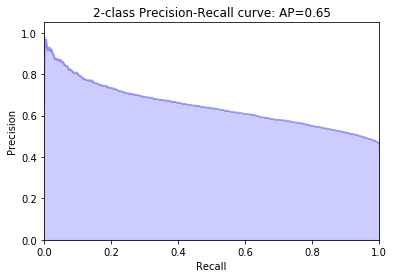

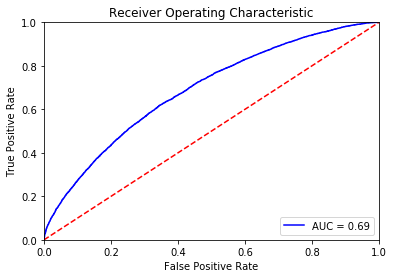

//anaconda3/lib/python3.7/site-packages/shap/explainers/linear.py:49: UserWarning:

The default value for feature_dependence has been changed to "independent"!



In [119]:
y = (data["readmitted"].astype('str')).apply(lambda x: 0 if x == "NO" else 1)
X_train, X_test, y_train, y_test = split_data(data,y) 
feature_engineering = FeatureEngineering()
encoded_training_data = feature_engineering.fit_transform(X_train,y_train)
lr_clf = LogisticRegression()
lr_clf.fit(encoded_training_data,y_train)
encoded_test_data = feature_engineering.transform(X_test)
generate_results(lr_clf,encoded_test_data,y_test)
lr_explainer = shap.LinearExplainer(lr_clf,encoded_training_data)
lr_shap_values = lr_explainer.shap_values(encoded_test_data)

In [120]:
shap.force_plot(lr_explainer.expected_value, lr_shap_values[0],list(feature_engineering.index_feature_map.values()))

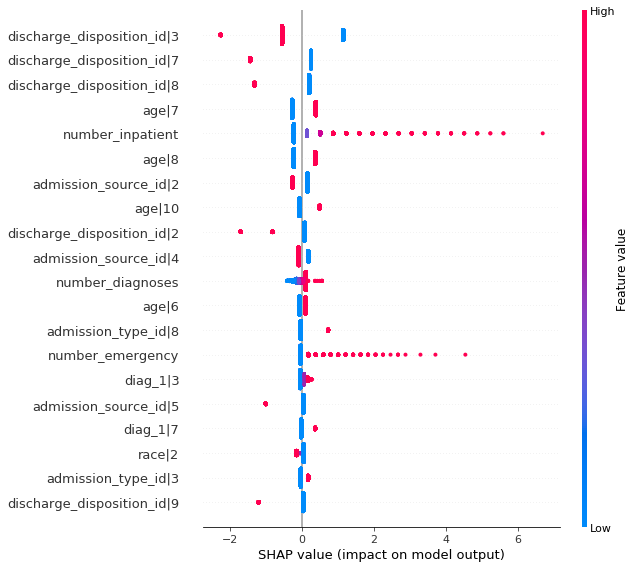

In [121]:
shap.summary_plot(lr_shap_values,encoded_test_data,list(feature_engineering.index_feature_map.values()))

GRADIENT BOOSTING DECISION TREES
==============================

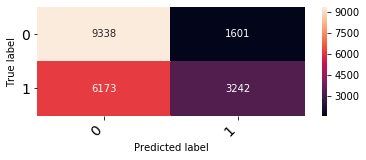

              precision    recall  f1-score   support

           0       0.60      0.85      0.71     10939
           1       0.67      0.34      0.45      9415

    accuracy                           0.62     20354
   macro avg       0.64      0.60      0.58     20354
weighted avg       0.63      0.62      0.59     20354

Average precision-recall score: 0.64


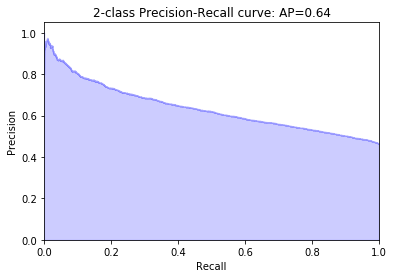

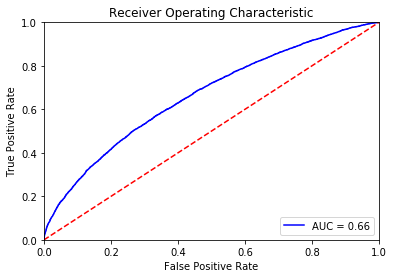

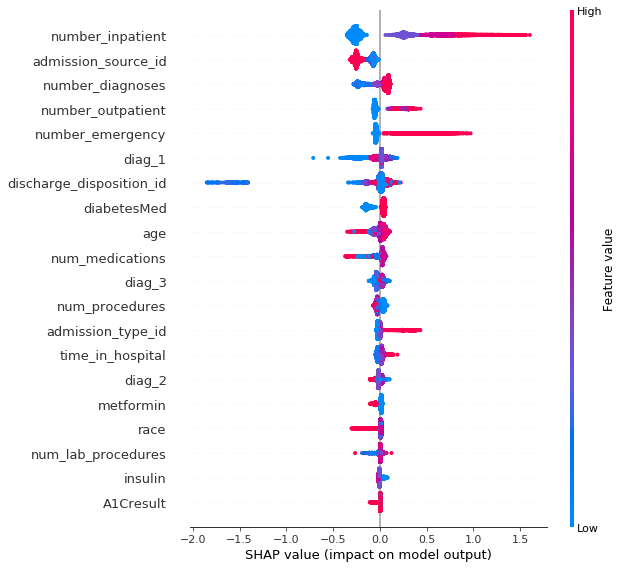

In [122]:
feature_engineering = FeatureEngineeringForTrees()
encoded_training_data = feature_engineering.fit_transform(X_train,y_train)
gbdt = GradientBoostingClassifier()
gbdt.fit(encoded_training_data,y_train)
encoded_test_data = feature_engineering.transform(X_test)
generate_results(gbdt,encoded_test_data,y_test)
gbdt_explainer = shap.TreeExplainer(gbdt)
gbdt_shap_values = gbdt_explainer.shap_values(encoded_test_data,y_test)
shap.summary_plot(gbdt_shap_values,encoded_test_data,list(feature_engineering.index_feature_map.values()))

In [123]:
shap.force_plot(gbdt_explainer.expected_value, gbdt_shap_values[:100],encoded_test_data,list(feature_engineering.index_feature_map.values()))

DEEP LEARNING
============

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Activation, ZeroPadding2D,Conv2D,Flatten,Conv1D,MaxPooling2D,BatchNormalization
from sklearn.metrics import roc_auc_score
import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

model = Sequential([
    Dense(200, activation="softmax"),
    Dense(50, activation="softmax"),
    Dense(10, activation="softmax"),
    Dense(2, activation="softmax"),
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.utils import to_categorical
y = (data["readmitted"].astype('str')).apply(lambda x: 0 if x == "NO" else 1)
y = to_categorical(y, num_classes=None, dtype='float32')
X_train, X_test, y_train, y_test = split_data(data,y)
feature_engineering = FeatureEngineering()
encoded_data = feature_engineering.fit(X_train,y_train)
encoded_data_test = feature_engineering.transform(X_test)
model.fit(encoded_data,y_train,epochs=300)
y_pred = model.predict_proba(encoded_data_test)

In [21]:
from sklearn.metrics import roc_auc_score
import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

print(roc_auc_score(y_test,y_pred))

0.6505771601666962


In [ ]:
dl_explainer = shap.DeepExplainer(model,encoded_data)
dl_shap_values = dl_explainer.shap_values(encoded_data_test)